In [2]:
'''
Available methods are the followings:
[1] BetaCalibration
[2] ABM_BetaCal
[3] AB_BetaCal
[4] AM_BetaCal
[5] Sigmoid_Cal
[6] ModifiedLogistic

Authors: Danusorn Sitdhirasdr <danusorn.si@gmail.com>
versionadded:: 20-09-2025

'''
import numpy as np
from collections import namedtuple
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.metrics import brier_score_loss, log_loss, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import column_or_1d, check_consistent_length
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.validation import (check_array, check_is_fitted, 
                                      _check_sample_weight, check_X_y)
from sklearn.utils.multiclass import type_of_target
from sklearn.exceptions import NotFittedError
from scipy.optimize import minimize_scalar, minimize

In [3]:
__all__ = ["BetaCalibration",
           "ABM_BetaCal",
           "AB_BetaCal",
           "AM_BetaCal", 
           "Sigmoid_Cal"]

In [4]:
class ValidateParams:
    
    '''Validate parameters'''
    
    def Interval(self, Param, Value, dtype=int, 
                 left=None, right=None, closed="both"):

        '''
        Validate numerical input.

        Parameters
        ----------
        Param : str
            Parameter's name

        Value : float or int
            Parameter's value

        dtype : {int, float}, default=int
            The type of input.

        left : float or int or None, default=None
            The left bound of the interval. None means left bound is -∞.

        right : float, int or None, default=None
            The right bound of the interval. None means right bound is +∞.

        closed : {"left", "right", "both", "neither"}
            Whether the interval is open or closed. Possible choices are:
            - "left": the interval is closed on the left and open on the 
              right. It is equivalent to the interval [ left, right ).
            - "right": the interval is closed on the right and open on the 
              left. It is equivalent to the interval ( left, right ].
            - "both": the interval is closed.
              It is equivalent to the interval [ left, right ].
            - "neither": the interval is open.
              It is equivalent to the interval ( left, right ).

        Returns
        -------
        Value : float or int
            Parameter's value

        '''
        Options = {"left"    : (np.greater_equal, np.less), # a<=x<b
                   "right"   : (np.greater, np.less_equal), # a<x<=b
                   "both"    : (np.greater_equal, np.less_equal), # a<=x<=b
                   "neither" : (np.greater, np.less)} # a<x<b

        f0, f1 = Options[closed]
        c0 = "[" if f0.__name__.find("eq")>-1 else "(" 
        c1 = "]" if f1.__name__.find("eq")>-1 else ")"
        v0 = "-∞" if left is None else str(dtype(left))
        v1 = "+∞" if right is None else str(dtype(right))
        if left  is None: left  = -np.inf
        if right is None: right = +np.inf
        interval = ", ".join([c0+v0, v1+c1])
        tuples = (Param, dtype.__name__, interval, Value)
        err_msg = "%s must be %s or in %s, got %s " % tuples    

        if isinstance(Value, dtype):
            if not (f0(Value, left) & f1(Value, right)):
                raise ValueError(err_msg)
        else: raise ValueError(err_msg)
        return Value

    def StrOptions(self, Param, Value, options, dtype=str):

        '''
        Validate string or boolean inputs.

        Parameters
        ----------
        Param : str
            Parameter's name
            
        Value : float or int
            Parameter's value

        options : set of str
            The set of valid strings.

        dtype : {str, bool}, default=str
            The type of input.
        
        Returns
        -------
        Value : float or int
            Parameter's value

        '''
        if Value not in options:
            err_msg = f'{Param} ({dtype.__name__}) must be either '
            for n,s in enumerate(options):
                if n<len(options)-1: err_msg += f'"{s}", '
                else: err_msg += f' or "{s}" , got %s'
            raise ValueError(err_msg % Value)
        return Value
    
    def check_range(self, param0, param1):
        
        '''
        Validate number range.
        
        Parameters
        ----------
        param0 : tuple(str, float)
            A lower bound parameter e.g. ("name", -100.)
            
        param1 : tuple(str, float)
            An upper bound parameter e.g. ("name", 100.)
            
        '''
        if param0[1] >= param1[1]:
            raise ValueError(f"`{param0[0]}` ({param0[1]}) must be less"
                             f" than `{param1[0]}` ({param1[1]}).")
            
    def check_y_inputs(self, y_proba, y_true=None):
        
        '''
        Validate inputs for calibration models.

        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Predicted probabilities ranges from 0 to 1.
            
        y_true : array-like, shape (n_samples,), default=None
            True binary labels (0/1).
            
        Returns
        -------
        y_proba : ndarray shape (n_samples,)
            Validated probabilities.
            
        y_true : ndarray shape (n_samples,)
            Validated labels. This returns None when `y_ture` is not 
            provided.
            
        '''
        # Ensure shapes
        y_proba = column_or_1d(y_proba)
        y_proba = check_array(y_proba, ensure_2d=False, dtype=float)

        # Probability range
        eps = np.finfo(float).eps
        y_proba = np.clip(y_proba, eps, 1 - eps)
        
        if y_true is not None:
            
            # Check lengths
            y_true = column_or_1d(y_true)
            check_consistent_length(y_proba, y_true)

            # Check that y_true only contains {0,1}
            unique_labels = np.unique(y_true)
            if not np.all(np.isin(unique_labels, [0, 1])):
                raise ValueError("`y_true` must be binary (0 or 1).")
            return y_proba, y_true
        
        else: return y_proba, None
        
    def check_class_weight(self, class_weight):
        
        '''
        Validate the `class_weight` parameter.

        Parameters
        ----------
        class_weight : {dict, "balanced"} or None
            Weights associated with classes in the form `{label: weight}`.
            If set to "balanced", the weights are automatically adjusted
            inversely proportional to class frequencies.

        Returns
        -------
        class_weight : dict, str or None
            Normalized class_weight.
            
        '''
         # Validate the `class_weight` parameter.
        if class_weight is None:
            return None
        elif isinstance(class_weight, str):
            args = ("class_weight", class_weight, ["balanced"], str)
            return self.StrOptions(*args)
        elif isinstance(class_weight, dict):
            return class_weight
        else:raise ValueError(f"Invalid value for `class_weight`: {class_weight}. "
                              f"Expected dict, 'balanced', or None.")
            
    def check_estimator(self, estimator):
        
        '''
        Validate that an estimator follows sklearn interface.

        Parameters
        ----------
        estimator : object
            Estimator instance.

        Raises
        ------
        ValueError
            If estimator does not implement required methods/attributes.
            
        '''
        for m in ["get_params", "set_params", "fit", "predict", "predict_proba"]:
            if not callable(getattr(estimator, m, None)):
                raise ValueError(f"Estimator missing required method `{m}()`.")

        if estimator.get_params().get("fit_intercept", None) is None:
            raise ValueError("Estimator missing required parameter "
                             "`fit_intercept` in get_params().")
        
        # Fit model with dummy X and y
        N, rnd = 10, np.random.RandomState(0)
        estimator.fit(rnd.rand(N).reshape(-1,1), 
                      rnd.randint(0, 2, size=N))
        
        for a in ["coef_", "intercept_"]:
            if getattr(estimator, a, None) is None:
                raise ValueError(f"Estimator missing required attribute "
                                 f"`{attr}` after fit().")

In [5]:
class EvaluateLoss:
    
    '''
    Utility class to evaluate model performance before and after 
    calibration.

    Metrics:
        - Brier score
        - Log loss
        
    '''
    
    @staticmethod
    def _gini(y_true, y_proba):
        
        '''
        Compute Gini coefficient from ROC AUC.
        '''
        return 2 * roc_auc_score(y_true, y_proba) - 1

    def evaluate(self, y_true, y_proba, y_calib):
        
        '''
        Evaluate loss metrics before and after calibration.

        Parameters
        ----------
        y_true : array-like of shape (n_samples,)
            Ground truth binary labels.

        y_proba : array-like of shape (n_samples,)
            Predicted probabilities before calibration.

        y_calib : array-like of shape (n_samples,)
            Predicted probabilities after calibration.

        Returns
        -------
        losses : namedtuple
            Pre and post calibration losses (Brier score and log-loss)
            
        '''
        a, b = (y_true, y_proba), (y_true, y_calib)
        losses = {"brier_score": [float(brier_score_loss(*a)), 
                                  float(brier_score_loss(*b))],
                  "log_loss"   : [float(log_loss(*a)), 
                                  float(log_loss(*b))]}
        
        return namedtuple("Losses", losses.keys())(**losses)

In [6]:
class ABM_BetaCal(BaseEstimator, RegressorMixin, ValidateParams, EvaluateLoss):
    
    '''
    Beta regression model with three parameters introduced in 
    Kull, M., Silva Filho, T.M. and Flach, P. (2017).
    Beta calibration: a well-founded and easily implemented 
    improvement on logistic calibration for binary classifiers.
    AISTATS 2017.
    
    Note
    ----
    This implementation is adapted from the `betacal` Python library 
    (https://github.com/dirmeier/betacal) with modifications.
    
    Parameters
    ----------
    estimator : estimator object, default=None
        Base estimator used for calibration. It must be compatible 
        with the scikit-learn regressor interface (supporting parameter 
        management, fitting, prediction, and probability estimation).  
        If None, defaults to LogisticRegression with parameters 
        `C=1e12`, and `fit_intercept=True`.

    Attributes
    ----------
    params_ : namedtuple
        Model parameters:
        - a : coefficient for log(p)
        - b : coefficient for log(1 - p)
        - c : intercept
        - m : midpoint
        
    calibrator_ : sklearn.linear_model.LogisticRegression
        Internal logistic regression used to train the model.
        
    losses_ : namedtuple
        Pre and post calibration losses (Brier score and log-loss).

    '''
    def __init__(self, estimator=None):
        
        if estimator is None:
            kwargs = dict(C=1e12, fit_intercept=True)
            self.estimator = LogisticRegression(**kwargs)
        else:
            self.check_estimator(estimator)
            estimator.set_params(**{"fit_intercept":False})
            self.estimator = estimator
        
    def __transform__(self, y_proba):
        
        '''
        Transform probabilities into 2D-array for logistic regression.
        
        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Probability estimates.
            
        Returns
        -------
        X : array-like, shape (n_samples, 2)
            Transformed X.
        
        '''
        eps = np.finfo(float).eps
        X = np.clip(y_proba, eps, 1 - eps).reshape(-1,1)
        X = np.log(np.hstack((X, 1.0 - X)))
        X[:, 1] *= -1
        
        return X
    
    def fit(self, y_proba, y_true, sample_weight=None):
        
        '''
        Fit the model using y_proba, y_true as training data.

        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Probability estimates.
            
        y_true : array-like, shape (n_samples,)
            Training data.

        sample_weight : array-like, shape = (n_samples,), default=None 
            Sample weights. If None, then samples are equally weighted.

        Returns
        -------
        self : object
            Returns an instance of self.
            
        '''
        # Validate inputs
        y_proba, y = self.check_y_inputs(y_proba, y_true)
        X = self.__transform__(y_proba)
     
        # Initial model fitting
        self.calibrator_ = clone(self.estimator).fit(X, y, sample_weight)
        a, b = self.calibrator_.coef_.ravel()
        self.index = [0,1]
        
        # Adjust if coefficients are negative
        if a < 0:
            self.index = [1]
            self.calibrator_.fit(X[:,self.index], y, sample_weight)
            a, b = 0, self.calibrator_.coef_.ravel()[0]
        elif b < 0:
            self.index = [0]
            self.calibrator_.fit(X[:,self.index], y, sample_weight)
            a, b = self.calibrator_.coef_.ravel()[0], 0

        c = self.calibrator_.intercept_[0]
        m = minimize_scalar(lambda m : np.abs(b*np.log(1.-m)-a*np.log(m)-c),
                            bounds=[0, 1], method='Bounded').x

        # Store related parameters
        values = {"a": float(a), "b": float(b), "c": float(c), "m": float(m)}
        self.params_ = namedtuple("Parameters", values.keys())(**values)
        
        # Losses before and after calibration
        y_calib = self.predict(y_proba)
        self.losses_ = self.evaluate(y, y_proba, y_calib)

        return self
    
    def predict(self, y_proba):
        
        '''
        Predict new values.

        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Probability estimates.

        Returns
        -------
        y_calib : array, shape (n_samples,)
            The predicted values.
            
        '''
        # Check if fit() was called
        check_is_fitted(self, ["params_", "calibrator_"])

        # Validate inputs
        y_proba, _ = self.check_y_inputs(y_proba, None)
        X = self.__transform__(y_proba)
        y_calib = self.calibrator_.predict_proba(X[:,self.index])[:,1]
        
        return y_calib

In [7]:
class AM_BetaCal(BaseEstimator, RegressorMixin, ValidateParams, EvaluateLoss):
    
    '''
    Beta regression model with two parameters (a and m, fixing a = b)
    introduced in Kull, M., Silva Filho, T.M. and Flach, P. Beta 
    calibration:a well-founded and easily implemented improvement on 
    logistic calibration for binary classifiers. AISTATS 2017.
    
    Note
    ----
    This implementation is adapted from the `betacal` Python library 
    (https://github.com/dirmeier/betacal) with modifications.
    
    Parameters
    ----------
    estimator : estimator object, default=None
        Base estimator used for calibration. It must be compatible 
        with the scikit-learn regressor interface (supporting parameter 
        management, fitting, prediction, and probability estimation).  
        If None, defaults to LogisticRegression with parameters 
        `C=1e12`, and `fit_intercept=True`.
        
    Attributes
    ----------
    params_ : namedtuple
        Model parameters:
        - a : coefficient for log(p / (1 - p))
        - b : a
        - c : intercept
        - m : midpoint
        
    calibrator_ : sklearn.linear_model.LogisticRegression
        Internal logistic regression used to train the model.
        
    losses_ : namedtuple
        Pre and post calibration losses (Brier score and log-loss).

    '''
    def __init__(self, estimator=None):
        
        if estimator is None:
            kwargs = dict(C=1e12, fit_intercept=True)
            self.estimator = LogisticRegression(**kwargs)
        else:
            self.check_estimator(estimator)
            estimator.set_params(**{"fit_intercept":True})
            self.estimator = estimator
        
    def __transform__(self, y_proba):
        
        '''
        Transform probabilities into 2D-array for logistic regression.
        
        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Probability estimates.
            
        Returns
        -------
        X : array-like, shape (n_samples, 1)
            Transformed X.
        
        '''
        eps = np.finfo(float).eps
        X = np.clip(y_proba, eps, 1 - eps).reshape(-1,1)
        X = np.log(X / (1. - X))
        
        return X
    
    def fit(self, y_proba, y_true, sample_weight=None):
        
        '''
        Fit the model using y_proba, y_true as training data.

        Parameters
        ----------
         y_proba : array-like, shape (n_samples,)
            Probability estimates.
            
        y_true : array-like, shape (n_samples,)
            Training data.

        sample_weight : array-like, shape = (n_samples,), default=None 
            Sample weights. If None, then samples are equally weighted.

        Returns
        -------
        self : object
            Returns an instance of self.
            
        '''
        # Validate inputs
        y_proba, y = self.check_y_inputs(y_proba, y_true)
        X = self.__transform__(y_proba)
     
        # Initial model fitting
        self.calibrator_ = clone(self.estimator).fit(X, y, sample_weight)
        a = self.calibrator_.coef_.ravel()[0]
        b = a 
        c = self.calibrator_.intercept_[0]  
        m = 1. / (1. + np.exp(c / a)) 

        # Store related parameters
        values = {"a": float(a), "b": float(b), "c": float(c), "m": float(m)}
        self.params_ = namedtuple("Parameters", values.keys())(**values)
        
        # Losses before and after calibration
        y_calib = self.predict(y_proba)
        self.losses_ = self.evaluate(y, y_proba, y_calib)

        return self
    
    def predict(self, y_proba):
        
        '''
        Predict new values.

        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Probability estimates.

        Returns
        -------
        y_calib : array, shape (n_samples,)
            The predicted values.
            
        '''
        # Check if fit() was called
        check_is_fitted(self, ["params_", "calibrator_"])
            
        # Validate inputs
        y_proba, _ = self.check_y_inputs(y_proba, None)
        X = self.__transform__(y_proba)
        y_calib = self.calibrator_.predict_proba(X)[:,1]
        
        return y_calib

In [8]:
class AB_BetaCal(BaseEstimator, RegressorMixin, ValidateParams, EvaluateLoss):
    
    '''
    Beta regression model with two parameters (a and b, fixing m = 0.5)
    introduced in Kull, M., Silva Filho, T.M. and Flach, P. Beta 
    calibration: a well-founded and easily implemented improvement on 
    logistic calibration for binary classifiers. AISTATS 2017.
    
    Note
    ----
    This implementation is adapted from the `betacal` Python library 
    (https://github.com/dirmeier/betacal) with modifications.
    
    Parameters
    ----------
    estimator : estimator object, default=None
        Base estimator used for calibration. It must be compatible 
        with the scikit-learn regressor interface (supporting parameter 
        management, fitting, prediction, and probability estimation).  
        If None, defaults to LogisticRegression with parameters 
        `C=1e12`, and `fit_intercept=True`.
        
    Attributes
    ----------
    params_ : namedtuple
        Model parameters:
        - a : coefficient for log(2^p) 
        - b : coefficient for log(2^(1-p)) 
        - c : 0.
        - m : midpoint
                
    calibrator_ : sklearn.linear_model.LogisticRegression
        Internal logistic regression used to train the model.
        
    losses_ : namedtuple
        Pre and post calibration losses (Brier score and log-loss).

    '''
    def __init__(self, estimator=None):
        
        if estimator is None:
            kwargs = dict(C=1e12, fit_intercept=False)
            self.estimator = LogisticRegression(**kwargs)
        else:
            self.check_estimator(estimator)
            estimator.set_params(**{"fit_intercept":False})
            self.estimator = estimator
            
    def __transform__(self, y_proba):
        
        '''
        Transform probabilities into 2D-array for logistic regression.
        
        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Probability estimates.
            
        Returns
        -------
        X : array-like, shape (n_samples, 2)
            Transformed X.
        
        '''
        eps = np.finfo(float).eps
        X = np.clip(y_proba, eps, 1 - eps).reshape(-1,1)
        X = np.hstack((X, 1. - X))
        X = np.log(2 * X)

        return X
    
    def fit(self, y_proba, y_true, sample_weight=None):
        
        '''
        Fit the model using y_proba, y_true as training data.

        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Probability estimates.
            
        y_true : array-like, shape (n_samples,)
            Training data.

        sample_weight : array-like, shape = (n_samples,), default=None 
            Sample weights. If None, then samples are equally weighted.

        Returns
        -------
        self : object
            Returns an instance of self.
            
        '''
        # Validate inputs
        y_proba, y = self.check_y_inputs(y_proba, y_true)
        X = self.__transform__(y_proba)
     
        # Initial model fitting
        self.calibrator_ = clone(self.estimator).fit(X, y, sample_weight)
        a, b = self.calibrator_.coef_.ravel() * np.r_[1,-1]
        c = 0
        m = 0.5

        # Store related parameters
        values = {"a": float(a), "b": float(b), "c": float(c), "m": float(m)}
        self.params_ = namedtuple("Parameters", values.keys())(**values)
        
        # Losses before and after calibration
        y_calib = self.predict(y_proba)
        self.losses_ = self.evaluate(y, y_proba, y_calib)
        
        return self
    
    def predict(self, y_proba):
        
        '''
        Predict new values.

        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Probability estimates.

        Returns
        -------
        y_calib : array, shape (n_samples,)
            The predicted values.
            
        '''
        # Check if fit() was called
        check_is_fitted(self, ["params_", "calibrator_"])
            
        # Validate inputs
        y_proba, _ = self.check_y_inputs(y_proba, None)
        X = self.__transform__(y_proba)
        y_calib = self.calibrator_.predict_proba(X)[:,1]
        
        return y_calib

In [9]:
class Sigmoid_Cal(BaseEstimator, RegressorMixin, ValidateParams, EvaluateLoss):
    
    '''
    Platt’s scaling is a probability calibration method introduced by 
    John Platt (1999) to turn raw classifier scores into well
    calibrated probabilities. Given a raw score $f(x)$, Platt’s 
    scaling models the probability of class 1 as: 
    
                    P(y=1|x) = 1 / (1 + exp(A.(x) + B)
    
    Parameters
    ----------
    estimator : estimator object, default=None
        Base estimator used for calibration. It must be compatible 
        with the scikit-learn regressor interface (supporting parameter 
        management, fitting, prediction, and probability estimation).  
        If None, defaults to LogisticRegression with parameters 
        `C=1e12`, and `fit_intercept=True`.

    Attributes
    ----------
    params_ : namedtuple
        Model parameters:
        - a : coefficient for p
        - b : a
        - c : intercept
        - m : midpoint
        
    calib_ : sklearn.linear_model.LogisticRegression
        Internal logistic regression used to train the model.
        
    losses_ : namedtuple
        Pre and post calibration losses (Brier score and log-loss).

    '''
    def __init__(self, estimator=None):
        
        if estimator is None:
            kwargs = dict(C=1e12, fit_intercept=True)
            self.estimator = LogisticRegression(**kwargs)
        else:
            self.check_estimator(estimator)
            estimator.set_params(**{"fit_intercept":True})
            self.estimator = estimator
            
    def __transform__(self, y_proba):
        
        '''
        Transform probabilities into 2D-array for logistic regression.
        
        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Probability estimates.
            
        Returns
        -------
        X : array-like, shape (n_samples, 2)
            Transformed X.
        
        '''
        eps = np.finfo(float).eps
        X = np.clip(y_proba, eps, 1 - eps).reshape(-1,1)

        return X
    
    def fit(self, y_proba, y_true, sample_weight=None):
        
        '''
        Fit the model using y_proba, y_true as training data.

        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Probability estimates.
            
        y_true : array-like, shape (n_samples,)
            Training data.
            
        sample_weight : array-like, shape = (n_samples,), default=None 
            Sample weights. If None, then samples are equally weighted.

        Returns
        -------
        self : object
            Returns an instance of self.
            
        '''
        # Validate inputs
        y_proba, y = self.check_y_inputs(y_proba, y_true)
        X = self.__transform__(y_proba)
     
        # Initial model fitting
        self.calibrator_ = clone(self.estimator).fit(X, y, sample_weight)
        a = self.calibrator_.coef_.ravel()[0]
        b = a
        c = self.calibrator_.intercept_[0]  
        m = -c/a

        # Store related parameters
        values = {"a": float(a), "b": float(b), "c": float(c), "m": float(m)}
        self.params_ = namedtuple("Parameters", values.keys())(**values)
        
        # Losses before and after calibration
        y_calib = self.predict(y_proba)
        self.losses_ = self.evaluate(y, y_proba, y_calib)

        return self
    
    def predict(self, y_proba):
        
        '''
        Predict new values.

        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Probability estimates.

        Returns
        -------
        y_calib : array, shape (n_samples,)
            The predicted values.
            
        '''
        # Check if fit() was called
        check_is_fitted(self, ["params_", "calibrator_"])
            
        # Validate inputs
        y_proba, _ = self.check_y_inputs(y_proba, None)
        X = self.__transform__(y_proba)
        y_calib = self.calibrator_.predict_proba(X)[:,1]
        
        return y_calib

In [81]:
class BetaCalibration(BaseEstimator, RegressorMixin, ValidateParams, EvaluateLoss):
    
    '''
    Wrapper class for the three Beta regression models introduced in 
    Kull, M., Silva Filho, T.M. and Flach, P. Beta calibration: a 
    well-founded and easily implemented improvement on logistic 
    calibration for binary classifiers. AISTATS 2017.

    Note
    ----
    This implementation is adapted from the `betacal` Python library 
    (https://github.com/dirmeier/betacal) with modifications.

    Parameters
    ----------
    estimator : estimator object, default=None
        Base estimator used for calibration. It must be compatible 
        with the scikit-learn regressor interface (supporting parameter 
        management, fitting, prediction, and probability estimation).  
        If None, defaults to LogisticRegression with parameters 
        `C=1e12`, and `fit_intercept=True`.
        
    parameters : {"abm", "am", "ab", "sigmoid"}, default="abm"
        Determines which parameters will be calculated by the model. 

    Attributes
    ----------
    calibrator_ : sklearn.linear_model.LogisticRegression
        Internal calibration model corresponding to the chosen 
        parameterization.

    '''
    def __init__(self, parameters="abm", estimator=None):
        
        if estimator is None:
            kwargs = dict(C=1e12, fit_intercept=True)
            self.estimator = LogisticRegression(**kwargs)
        else:
            self.check_estimator(estimator)
            self.estimator = estimator.set_params(**{"fit_intercept":True})
        
        params = {"abm": ABM_BetaCal(), "am": AM_BetaCal() , 
                  "ab": AB_BetaCal() , "sigmoid": Sigmoid_Cal()} 
        self.parameters = self.StrOptions("parameters", parameters, params.keys())
        self.calibrator_ = params[self.parameters]
        self.calibrator_.set_params(**{"estimator":self.estimator})

    def fit(self, y_proba, y_true, sample_weight=None):
        
        '''
        Fit the model using y_proba, y_true as training data.

        Parameters
        ----------
        y_true : array-like, shape (n_samples,)
            Training data.

        y_proba : array-like, shape (n_samples,)
            Probability estimates.
            
        sample_weight : array-like, shape = (n_samples,), default=None 
            Sample weights. If None, then samples are equally weighted.

        Returns
        -------
        self : object
            Returns an instance of self.
            
        '''
        self.calibrator_.fit(y_proba, y_true, sample_weight)
        return self

    def predict(self, y_proba):
        
        '''
        Predict new values.

        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Probability estimates.

        Returns
        -------
        y_calib : array, shape (n_samples,)
            The predicted values.

        '''
        # Check if fit() was called
        check_is_fitted(self, "calibrator_")
        return self.calibrator_.predict(y_proba)

In [117]:
class ModifiedLogistic(BaseEstimator, RegressorMixin, ValidateParams):
    
    '''
    Custom implementation of Logistic Regression using scipy's 
    `minimize` optimizer.

    Parameters
    ----------
    penalty : {"l1", "l2", "elasticnet", None}, default="l2"
        Type of regularization applied to the loss function.
        Specify the norm of the penalty:
    
    tol : float, default=1e-4
        Tolerance for stopping criteria.

    C : float, default=1.0
        Inverse of regularization strength; must be a positive float. 
        Like in support vector machines, smaller values specify 
        stronger regularization.

    fit_intercept : bool, default=True
        Whether to include an intercept term in the model.

    class_weight : dict or "balanced" or None, default=None
        Weights associated with classes in the form {label: weight}. 
        If not given, all classes are supposed to have weight one. 
        
    solver : str, default="BFGS"
        Algorithm to use in the optimization problem from scipy's 
        `minimize`, which are {"BFGS", "L-BFGS-B", "Nelder-Mead", 
        "Newton-CG", "CG"}.
     
    max_iter : int, default=1000
        Maximum number of iterations for the optimization solver.

    l1_ratio : float, default=0.5
        ElasticNet mixing parameter, with `0 <= l1_ratio <= 1`.
        - l1_ratio = 1 → L1 penalty
        - l1_ratio = 0 → L2 penalty
        - 0 < l1_ratio < 1 → combination of L1 and L2 penalties

    Attributes
    ----------
    res_ : OptimizeResult
        Full optimization result returned by `scipy.optimize.minimize`.
        Contains diagnostic information such as final parameters,
        convergence status, number of iterations, and gradient.

    coef_ : ndarray of shape (n_features,)
        Learned coefficients (weights) of the logistic regression model.

    intercept_ : ndarray of shape (1,)
        Intercept (bias) term added to the decision function.

    loss_ : list of float
        Sequence of loss values recorded at each optimization step.

    params_ : list of ndarray
        Sequence of parameter vectors (weights + intercept) evaluated
        during optimization.

    '''
    
    methods = ['l1', 'l2', 'elasticnet', None]
    solvers = ["BFGS", "L-BFGS-B", "Nelder-Mead", "Newton-CG", "CG"]
    
    def __init__(self, penalty="l2", tol=1e-4, C=1e4, fit_intercept=True, 
                 class_weight=None, solver="BFGS", max_iter=1000,  
                 l1_ratio=0.5):
        
        # Validate all parameters
        self.penalty = self.StrOptions('penalty', penalty, self.methods, str)
        self.tol = self.Interval("tol", tol, float, 0., 1., "both")
        self.C = self.Interval("C", C, float, 0., None, "left")
        self.fit_intercept = self.StrOptions('fit_intercept', fit_intercept, [True, False], bool)
        self.class_weight = self.check_class_weight(class_weight)
        self.solver = self.StrOptions('solver', solver, self.solvers, str)
        self.max_iter = self.Interval("max_iter", max_iter, int, 1, None, "left")
        self.l1_ratio = self.Interval("l1_ratio", l1_ratio, float, 0., 1., "both")
        self.xy_kwargs = dict(accept_sparse=True, dtype=float, 
                              ensure_2d=True, y_numeric=True)
        
        # Attributes
        self.loss_ = list()
        self.params_ = list()
        
    def fit(self, X, y, sample_weight=None):
        
        '''
        Fit the model according to the given training data.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training vector, where `n_samples` is the number of samples 
            and `n_features` is the number of features.

        y : array-like of shape (n_samples,)
            Target vector relative to X.

        sample_weight : array-like of shape (n_samples,) default=None
            Array of weights that are assigned to individual samples.
            If not provided, then each sample is given unit weight.
            
        References
        ----------
        [1] https://docs.scipy.org/doc/scipy/reference/generated/scipy.
            optimize.minimize.html
    
        Returns
        -------
        self
            Fitted estimator.
        
        '''
        # Validate inputs
        X, y = check_X_y(X, y, **self.xy_kwargs)
        self.n_features_ = X.shape[1]
        if type_of_target(y) != "binary":
            raise ValueError("This estimator only supports binary targets.")
        
        # Initialize sample weights
        sample_weight = _check_sample_weight(sample_weight, X)

        # Default parameters
        params = np.zeros(self.n_features_ + self.fit_intercept)
        
        # Apply class_weight if provided
        if isinstance(self.class_weight, str):
            classes = np.unique(y)
            weights = compute_class_weight(self.class_weight, 
                                           classes=classes, y=y)
            weights = dict(zip(classes, weights))
        elif isinstance(self.class_weight, dict):
            weights = self.class_weight
        else: weights = None
            
        # `class_weight` x `sample_weight`
        if isinstance(weights, dict):
            sample_weight *= np.where(y==0, weights[0], weights[1])
 
        # Optimizer
        res = minimize(fun=lambda params: self.__optimize__(params, X, y, sample_weight)[0],
                       x0=np.zeros(len(params)),
                       jac=lambda params: self.__optimize__(params, X, y, sample_weight)[1],
                       method=self.solver, 
                       tol=self.tol,
                       options={"maxiter":self.max_iter})
        
        self.coef_ = res.x[:-1]
        self.intercept_ = np.r_[res.x[-1]]
        self.n_iter_ = res.nit
        self.res_ = res
        
        return self
    
    def __optimize__(self, params, X, y, sample_weight):
        
        '''
        Compute loss and gradient for optimization.

        Parameters
        ----------
        params : ndarray of shape (n_features + 1,)
            Flattened array of weights and bias.

        X : ndarray of shape (n_samples, n_features)
            Training data.

        y : ndarray of shape (n_samples,)
            True labels.
            
        sample_weight : array-like of shape (n_samples,) 
            Array of weights that are assigned to individual samples.

        Returns
        -------
        loss : float
            Logistic loss with regularization.

        gradients : ndarray of shape (n_features + 1,)
            Gradient of the loss with respect to weights and bias.
        
        '''
        if self.fit_intercept:
            w = params[:-1]
            b = params[-1]
        else:
            w = params
            b = 0.0

        # Compute score
        z = X @ w + b
        y_pred = 1 / (1 + np.exp(-z))
        
        # Loss with penalty
        loss = log_loss(y, y_pred, sample_weight=sample_weight) + self.__penalty__(w)
        self.loss_.append(loss)

        # Compute gradients
        error = (y_pred - y) * sample_weight
        dw = (X.T @ error) / np.sum(sample_weight) + self.__regularization__(w)
        db = np.sum(error) / np.sum(sample_weight) if self.fit_intercept else 0.
        
        gradients = np.r_[dw, db] if self.fit_intercept else np.r_[dw]
        self.params_.append(params)
        
        return loss, gradients
    
    def __penalty__(self, w):
        
        '''
        Compute the penalty term for the loss function. The degree of
        penalties depends on weights, regularization strength, and 
        `l1_ratio` (only relevant when "elasticnet" is selected)

        Parameters
        ----------
        w : ndarray of shape (n_features,)
            Model weights.

        Returns
        -------
        penalty : float
            Penalty value added to the loss.
            
        '''
        l1 = 1 / self.C * np.sum(np.abs(w))
        l2 = 0.5 * 1 / self.C * np.sum(w**2)
        
        if self.penalty is None:
            return 0
        elif self.penalty == "l1":
            return l1 
        elif self.penalty == "l2":
            return l2
        elif self.penalty == "elasticnet":
            return self.l1_ratio * l1 + (1 - self.l1_ratio) * l2
    
    def __regularization__(self, w):
        
        '''
        Compute the regularization term for the gradient. 
        
        Parameters
        ----------
        w : ndarray of shape (n_features,)
            Model weights.

        Returns
        -------
        grad_penalty : ndarray of shape (n_features,)
            The array of penalties with respect to `w`. 
            
        '''
        l1 = 1 / self.C * np.sign(w)
        l2 = 1 / self.C * w
        
        if self.penalty is None: 
            return 0
        elif self.penalty == "l1":
            return l1
        elif self.penalty == "l2":
            return l2
        elif self.penalty == "elasticnet":
            return self.l1_ratio * l1 + (1 - self.l1_ratio) * l2
        
    def predict_proba(self, X):
        
        '''
        Predict class probabilities for input samples.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Input samples.

        Returns
        -------
        y_proba : ndarray of shape (n_samples, 2)
            Probability estimates for the negative and positive class.
        
        '''
        X = check_X_y(X, np.ones(len(X)), **self.xy_kwargs)[0]
        z = X @ self.coef_ + self.intercept_
        y_proba = 1 / (1 + np.exp(-z))
        return np.vstack([1 - y_proba, y_proba]).T

    def predict(self, X, threshold=0.5):
        
        '''
        Predict binary labels for input samples.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Input samples.

        threshold : float, default=0.5
            Threshold used to assign class labels.

        Returns
        -------
        y_pred : ndarray of shape (n_samples,)
            Predicted class labels (0 or 1).
            
        '''
        y_proba = self.predict_proba(X)
        return np.where(y_proba >= threshold, 1, 0)

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
X = pd.read_csv('HL_online_fraud.csv')

In [13]:
X.head()

,dataset,raw_score,calibrated_score,quantiled_calibrated_score,target
0,train,0.000780,0.005857,-0.343981,0
1,train,0.000535,0.005847,-0.665472,0
2,train,0.002743,0.005876,0.009397,0
3,train,0.000077,0.005840,-1.299295,0
4,train,0.000686,0.005845,-0.824825,0


In [14]:
probs_cal = X.loc[X["dataset"]=="test","raw_score"].values
y_cal = X.loc[X["dataset"]=="test","target"].values
probs_eval = X.loc[X["dataset"]=="train","raw_score"].values
y_eval = X.loc[X["dataset"]=="train","target"].values

In [83]:
a = BetaCalibration("ab", LogisticRegression(C=0.001, fit_intercept=False))
a.fit(probs_cal, y_cal)
# print(a.calibrator_.estimator.get_params())
print(a.calibrator_.params_)
print(a.calibrator_.losses_)
X = a.calibrator_.__transform__(probs_cal.reshape(-1,1))

Parameters(a=0.042975873186836815, b=0.005138928638810374, c=0.0, m=0.5)
Losses(brier_score=[0.03543610488671236, 0.017233992475398342], log_loss=[0.13450623678484486, 0.0871611620571625])


In [38]:
# a = BetaCalibration("am")
# a.fit(probs_cal, y_cal)
# print(a.calibrator_.params_)
# print(a.calibrator_.losses_)
# X = a.calibrator_.__transform__(probs_cal.reshape(-1,1))

In [37]:
# a = BetaCalibration("ab")
# a.fit(probs_cal, y_cal)
# print(a.calibrator_.params_)
# print(a.calibrator_.losses_)
# X = a.calibrator_.__transform__(probs_cal.reshape(-1,1))

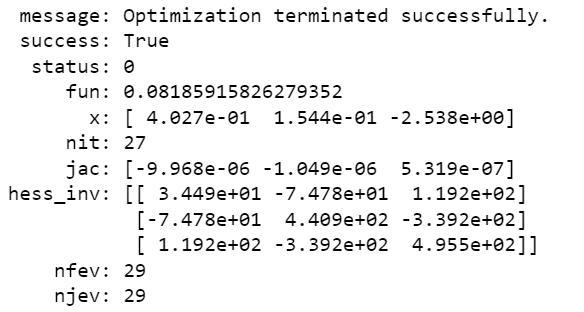

In [98]:
a = BetaCalibration("am")
a.fit(probs_cal, y_cal)
# print(a.calibrator_.estimator.get_params())
print(a.calibrator_.params_)
print(a.calibrator_.losses_)
X = a.calibrator_.__transform__(probs_cal.reshape(-1,1))

Parameters(a=0.361677744555606, b=0.361677744555606, c=-2.7197166674738966, m=0.9994580114730813)
Losses(brier_score=[0.03543610488671236, 0.017005215413594246], log_loss=[0.13450623678484486, 0.08191351747143015])


In [118]:
model = ModifiedLogistic(penalty="elasticnet", tol=1e-4, C=1e12, fit_intercept=True, 
                 class_weight="balanced", solver="L-BFGS-B", max_iter=100,  
                 l1_ratio=0.6)
model.fit(X, y_cal)
model.res_

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.6008582065808956
        x: [ 3.797e-01  1.369e+00]
      nit: 9
      jac: [-8.046e-04  4.493e-04]
     nfev: 11
     njev: 11
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [122]:
a = BetaCalibration("am", ModifiedLogistic(penalty="elasticnet", 
                                           tol=1e-4, C=1e12, 
                                           fit_intercept=True, 
                                           class_weight={0:100,1:2}, 
                                           solver="L-BFGS-B", 
                                           max_iter=100,  
                                           l1_ratio=0.6))
a.fit(probs_cal, y_cal)
# print(a.calibrator_.estimator.get_params())
print(a.calibrator_.params_)
print(a.calibrator_.losses_)
X = a.calibrator_.__transform__(probs_cal.reshape(-1,1))

Parameters(a=0.4419318904945563, b=0.4419318904945563, c=-6.269642963778159, m=0.999999310224319)
Losses(brier_score=[0.03543610488671236, 0.01755714706954703], log_loss=[0.13450623678484486, 0.1304699905682189])


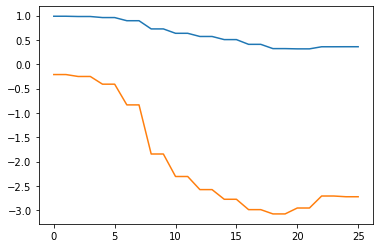

In [101]:
plt.plot(np.array(model.params_)[2:,0])
plt.plot(np.array(model.params_)[2:,1])
# plt.plot(np.array(model.params_)[2:,2])

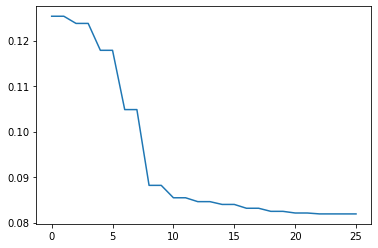

In [104]:
plt.plot(model.loss_[2:])